In [ ]:
# run in Colab cell
!pip install -q --upgrade pip
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q transformers sentencepiece torch torchv5ision torchaudio
!pip install -q googletrans==4.0.0-rc1 textblob gradio pandas matplotlib seaborn folium
# textblob corpora
!python -m textblob.download_corpora -q


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [ ]:
import os, io, json, uuid, datetime, tempfile
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import whisper
from googletrans import Translator
from textblob import TextBlob
import gradio as gr

In [ ]:
!pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
google-adk 1.16.0 requires websockets<16.0.0,>=15.0.1, but you have webs

In [ ]:
!pip install --upgrade --force-reinstall pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 91.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 110.5 MB/s  0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling tzdata-2025.2:
      Successfully uninstalled tzdata-2025.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1.17.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.9.0.post0
    Uninstalling python-dateutil-2.9.0.post0:
      Successfully uninstalled python-dateutil-2.9.0.post0
  Attempting uninstall: pandas
    Found exis

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Whisper for STT (choose 'small' or 'base' for speed; 'medium' for quality)
WHISPER_SIZE = "small"
print("Loading Whisper model (this can take a minute)...")
whisper_model = whisper.load_model(WHISPER_SIZE).to(device)

# Emotion model (English checkpoint). For production, swap with a multilingual fine-tuned model.
EMOTION_MODEL = "j-hartmann/emotion-english-distilroberta-base"
print("Loading emotion model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(EMOTION_MODEL)
text_emotion_model = AutoModelForSequenceClassification.from_pretrained(EMOTION_MODEL).to(device)
emotion_pipe = pipeline("text-classification", model=text_emotion_model, tokenizer=tokenizer, return_all_scores=True, device=0 if device=="cuda" else -1)

translator = Translator()
print("Models loaded.")


Device: cpu
Loading Whisper model (this can take a minute)...
Loading emotion model and tokenizer...


Device set to use cpu


Models loaded.


In [ ]:
def transcribe_audio_whisper(audio_path):
    """Transcribe audio file path with Whisper; returns transcript and detected language code."""
    # Whisper expects path and returns dict
    result = whisper_model.transcribe(audio_path, task="transcribe")
    text = result.get("text", "").strip()
    # whisper may include language key when detect_language is true
    lang = result.get("language", None)
    return text, lang

def detect_language_google(text):
    try:
        res = translator.detect(text)
        return res.lang
    except Exception:
        return None

def translate_to_english(text, src_lang=None):
    """Translate using googletrans (best-effort). If src_lang is None, translator.auto-detects."""
    try:
        if src_lang:
            out = translator.translate(text, src=src_lang, dest="en")
        else:
            out = translator.translate(text, dest="en")
        return out.text
    except Exception:
        return text

def predict_emotion_text(text, topk=5):
    """Return sorted emotion scores from the model (English)."""
    # The pipeline returns list-of-dicts in a nested list since return_all_scores=True
    try:
        res = emotion_pipe(text[:512])  # truncate long text
    except Exception as e:
        # fallback to tokenized model call if pipeline has issues
        inputs = tokenizer(text[:512], return_tensors="pt", truncation=True).to(device)
        with torch.no_grad():
            logits = text_emotion_model(**inputs).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
        labels = text_emotion_model.config.id2label
        res = [[{"label": labels[str(i)], "score": float(probs[i])} for i in range(len(probs))]]
    scores = res[0]
    scores_sorted = sorted(scores, key=lambda x: x['score'], reverse=True)
    return scores_sorted[:topk], {s['label']: s['score'] for s in scores_sorted}

def predict_sentiment_text(text):
    """Simple polarity via TextBlob (works on English)."""
    try:
        blob = TextBlob(text)
        pol = blob.sentiment.polarity
        if pol > 0.1:
            sentiment = "positive"
        elif pol < -0.1:
            sentiment = "negative"
        else:
            sentiment = "neutral"
    except Exception:
        sentiment = "neutral"
        pol = 0.0
    return sentiment, pol


In [ ]:
def analyze_single_record(text_input=None, audio_path=None, translate=True):
    """
    Accept either text_input (str) or audio_path (local path to audio).
    Returns dict with language, translated_text, emotion_scores, sentiment.
    """
    out = {"id": str(uuid.uuid4()), "timestamp": datetime.datetime.utcnow().isoformat()+"Z"}
    raw_text = ""
    detected_lang = None

    if audio_path:
        raw_text, detected_lang = transcribe_audio_whisper(audio_path)
        out['source'] = 'audio'
    elif text_input:
        raw_text = text_input
        # detect language
        detected_lang = detect_language_google(raw_text)
        out['source'] = 'text'
    else:
        raise ValueError("Provide text_input or audio_path")

    out['raw_text'] = raw_text
    out['detected_language'] = detected_lang

    # Translate if necessary (model is English)
    if translate and detected_lang and detected_lang != 'en':
        eng_text = translate_to_english(raw_text, src_lang=detected_lang)
    else:
        # if detection failed, try translator auto-detect
        if translate:
            eng_text = translate_to_english(raw_text)
        else:
            eng_text = raw_text

    out['translated_text'] = eng_text

    # Emotion + Sentiment
    emotion_topk, emotion_probs = predict_emotion_text(eng_text)
    sentiment, polarity = predict_sentiment_text(eng_text)

    out['emotion_topk'] = emotion_topk
    out['emotion_probs'] = emotion_probs
    out['sentiment'] = sentiment
    out['polarity'] = polarity
    return out


In [ ]:
def plot_emotion_bar(emotion_topk, title="Top Emotions"):
    labels = [e['label'] for e in emotion_topk]
    scores = [e['score'] for e in emotion_topk]
    plt.figure(figsize=(6,3))
    sns.barplot(x=scores, y=labels, palette="vlag")
    plt.xlim(0,1)
    plt.title(title)
    plt.xlabel("Probability")
    plt.show()

def plot_batch_emotion_distribution(df, emotion_col='predicted_emotion'):
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=emotion_col, order=df[emotion_col].value_counts().index)
    plt.title("Emotion distribution (batch)")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
# create a sample dataset (you can upload your CSV later)
sample = [
    {"product_id":"P001","timestamp":"2025-10-20","language":"en","review":"This phone has amazing battery life and camera."},
    {"product_id":"P002","timestamp":"2025-10-21","language":"hi","review":"यह उत्पाद बहुत खराब है, बिलकुल संतुष्ट नहीं हूँ"},  # Hindi: very bad
    {"product_id":"P001","timestamp":"2025-10-22","language":"ta","review":"இந்த தயாரிப்பு அற்புதமாக உள்ளது, பரிந்துரைக்கிறேன்"},  # Tamil: wonderful
    {"product_id":"P003","timestamp":"2025-10-23","language":"ml","review":"ഉൽപ്പന്നം വലുതാണ്, ഒരുപാട് ഇഷ്ടപ്പെട്ടു"},  # Malayalam: liked
    {"product_id":"P002","timestamp":"2025-10-24","language":"te","review":"ఈ ఉత్పత్తి నా ఆశలను తీర్చలేదు"}   # Telugu: disappointed
]
sample_df = pd.DataFrame(sample)
sample_df.to_csv("sample_reviews.csv", index=False)
print("Sample CSV saved to /content/sample_reviews.csv")
sample_df.head()


Sample CSV saved to /content/sample_reviews.csv


,product_id,timestamp,language,review
0,P001,2025-10-20,en,This phone has amazing battery life and camera.
1,P002,2025-10-21,hi,"यह उत्पाद बहुत खराब है, बिलकुल संतुष्ट नहीं हूँ"
2,P001,2025-10-22,ta,"இந்த தயாரிப்பு அற்புதமாக உள்ளது, பரிந்துரைக்கி..."
3,P003,2025-10-23,ml,"ഉൽപ്പന്നം വലുതാണ്, ഒരുപാട് ഇഷ്ടപ്പെട്ടു"
4,P002,2025-10-24,te,ఈ ఉత్పత్తి నా ఆశలను తీర్చలేదు


In [ ]:
def process_batch_csv(csv_path, translate=True, save_to="batch_results.csv"):
    df = pd.read_csv(csv_path)
    results = []
    for idx, row in df.iterrows():
        text = str(row.get("review",""))
        # try to trust language col if present
        lang = row.get("language", None)
        # analyze
        rec = analyze_single_record(text_input=text if text else None, audio_path=None, translate=translate)
        # pick top emotion (label of max)
        top_em = rec['emotion_topk'][0]['label'] if rec['emotion_topk'] else None
        rec_out = {
            "product_id": row.get("product_id", ""),
            "timestamp": row.get("timestamp", ""),
            "original_text": text,
            "detected_language": rec.get("detected_language"),
            "translated_text": rec.get("translated_text"),
            "predicted_emotion": top_em,
            "emotion_scores": json.dumps(rec.get("emotion_probs")),
            "sentiment": rec.get("sentiment"),
            "polarity": rec.get("polarity")
        }
        results.append(rec_out)
    out_df = pd.DataFrame(results)
    out_df.to_csv(save_to, index=False)
    print(f"Batch processed. Results saved to {save_to}")
    return out_df

# quick test of batch processing on the sample CSV
batch_df = process_batch_csv("sample_reviews.csv")
batch_df.head()


/tmp/ipython-input-2424405011.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  out = {"id": str(uuid.uuid4()), "timestamp": datetime.datetime.utcnow().isoformat()+"Z"}


Batch processed. Results saved to batch_results.csv


,product_id,timestamp,original_text,detected_language,translated_text,predicted_emotion,emotion_scores,sentiment,polarity
0,P001,2025-10-20,This phone has amazing battery life and camera.,en,This phone has amazing battery life and camera.,neutral,"{""neutral"": 0.5519083738327026, ""surprise"": 0....",positive,0.60
1,P002,2025-10-21,"यह उत्पाद बहुत खराब है, बिलकुल संतुष्ट नहीं हूँ",hi,"This product is very bad, not satisfied at all",disgust,"{""disgust"": 0.8828374743461609, ""anger"": 0.056...",negative,-0.58
2,P001,2025-10-22,"இந்த தயாரிப்பு அற்புதமாக உள்ளது, பரிந்துரைக்கி...",ta,"This product is amazing, would recommend",joy,"{""joy"": 0.4836767017841339, ""surprise"": 0.3881...",positive,0.60
3,P003,2025-10-23,"ഉൽപ്പന്നം വലുതാണ്, ഒരുപാട് ഇഷ്ടപ്പെട്ടു",ml,"The product is great, liked a lot",joy,"{""joy"": 0.9541783332824707, ""neutral"": 0.03192...",positive,0.70
4,P002,2025-10-24,ఈ ఉత్పత్తి నా ఆశలను తీర్చలేదు,te,This product did not meet my expectations,sadness,"{""sadness"": 0.6031743288040161, ""neutral"": 0.2...",neutral,0.00


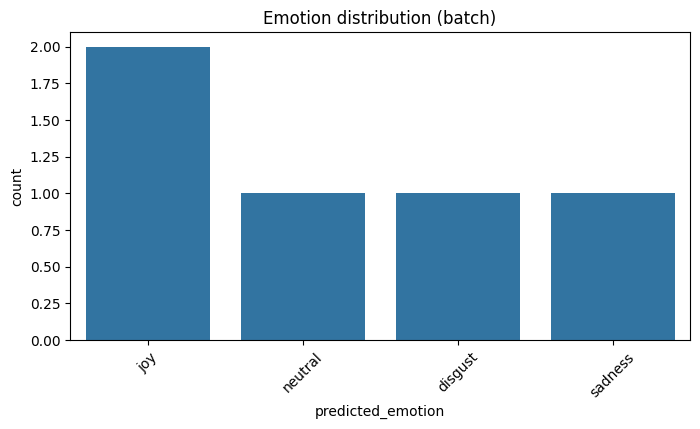

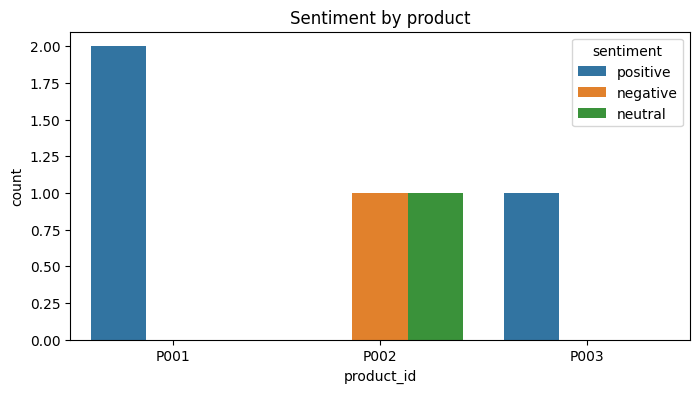

Negative reviews by product:
  product_id  negative_count
0       P002               1


In [ ]:
# Emotion distribution overall
plot_batch_emotion_distribution(batch_df, emotion_col='predicted_emotion')

# Sentiment counts by product
plt.figure(figsize=(8,4))
sns.countplot(data=batch_df, x='product_id', hue='sentiment')
plt.title("Sentiment by product")
plt.show()

# Quick table of negative reviews per product
neg_counts = batch_df[batch_df['sentiment']=="negative"].groupby("product_id").size().reset_index(name="negative_count")
print("Negative reviews by product:")
print(neg_counts)


Do you want to give input as (1) Text or (2) Voice? Enter 1 or 2: 1
✍️ Enter your feedback (any language): இந்த பொருள் மிகவும் நன்றாக உள்ளது.


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



📊 --- Analysis Result ---
Original Text: இந்த பொருள் மிகவும் நன்றாக உள்ளது.
Detected Language: ta
Translated Text: This material is very good.
Sentiment: Positive
Emotion: Happiness 😊
Confidence: 0.915


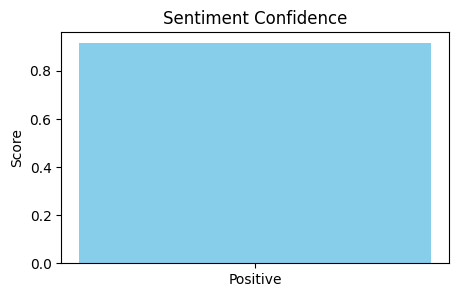

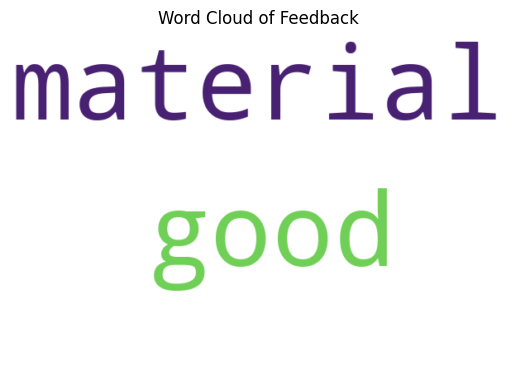

In [ ]:
# ==============================================================
# 🌍 Multilingual Emotion + Sentiment Analysis with Voice Support
# Domain: E-commerce Customer Reviews
# ==============================================================

!pip install transformers torch googletrans==4.0.0-rc1 gTTS SpeechRecognition pydub langdetect matplotlib wordcloud librosa soundfile > /dev/null

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from googletrans import Translator
from langdetect import detect
import speech_recognition as sr
from gtts import gTTS
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# --------------------------------------------------------------
# 1️⃣ Load multilingual sentiment model
# --------------------------------------------------------------
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = ['Negative', 'Neutral', 'Positive']
translator = Translator()

# --------------------------------------------------------------
# 2️⃣ Function: Analyze sentiment and emotion
# --------------------------------------------------------------
def analyze_text(text):
    try:
        lang = detect(text)
    except:
        lang = "unknown"
    translated = translator.translate(text, src=lang, dest='en').text

    inputs = tokenizer(translated, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=1).numpy()[0]

    sentiment = labels[scores.argmax()]
    emotion_map = {"Positive": "Happiness 😊", "Negative": "Anger 😡", "Neutral": "Neutral 😐"}
    emotion = emotion_map[sentiment]

    result = {
        "Original Text": text,
        "Detected Language": lang,
        "Translated Text": translated,
        "Sentiment": sentiment,
        "Emotion": emotion,
        "Confidence": round(float(max(scores)), 3)
    }
    return result

# --------------------------------------------------------------
# 3️⃣ Function: Speech-to-Text (Voice Input)
# --------------------------------------------------------------
def get_voice_input():
    recognizer = sr.Recognizer()
    with sr.Microphone() as source:
        print("\n🎙️ Speak your product feedback (in any language)...")
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.listen(source)
    try:
        print("🔍 Recognizing...")
        text = recognizer.recognize_google(audio, language="hi-IN")
        print(f"🗣️ You said: {text}")
        return text
    except Exception as e:
        print("⚠️ Could not process audio:", e)
        return None

# --------------------------------------------------------------
# 4️⃣ Function: Text-to-Speech (Output Response)
# --------------------------------------------------------------
def speak_output(text, lang='en'):
    tts = gTTS(text=text, lang=lang)
    tts.save("response.mp3")
    display(Audio("response.mp3", autoplay=True))

# --------------------------------------------------------------
# 5️⃣ Demo: Take Input (Either Text or Voice)
# --------------------------------------------------------------
choice = input("Do you want to give input as (1) Text or (2) Voice? Enter 1 or 2: ")

if choice == '2':
    user_input = get_voice_input()
else:
    user_input = input("✍️ Enter your feedback (any language): ")

if user_input:
    result = analyze_text(user_input)
    print("\n📊 --- Analysis Result ---")
    for k, v in result.items():
        print(f"{k}: {v}")

    # ----------------------------------------------------------
    # Visualization: Sentiment Bar Chart
    # ----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(5, 3))
    plt.bar(result['Sentiment'], result['Confidence'], color='skyblue')
    plt.title("Sentiment Confidence")
    plt.ylabel("Score")
    plt.show()

    # ----------------------------------------------------------
    # WordCloud of Translated Text
    # ----------------------------------------------------------
    wc = WordCloud(width=600, height=400, background_color="white").generate(result['Translated Text'])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of Feedback")
    plt.show()

    # ----------------------------------------------------------
    # Speak Result
    # ----------------------------------------------------------
    response_text = f"The sentiment is {result['Sentiment']} and emotion detected is {result['Emotion']}."
    speak_output(response_text, lang='en')
else:
    print("❌ No input provided.")


In [ ]:
!pip install PyAudio

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for PyAudio (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for PyAudio
Failed to build PyAudio
error: failed-wheel-build-for-install

× Failed to build installable wheels for some pyproject.toml based projects
╰─> PyAudio


📋 Sample of dataset:


,review
0,This product is really good and works perfectly!
1,Le produit est cassé et ne fonctionne pas.
2,El envío fue muy rápido y el empaque excelente.
3,இந்த பொருள் தரம் மிகவும் மோசமாக உள்ளது.
4,"Das ist ein erstaunliches Produkt, sehr zufrie..."


  0%|          | 0/10 [00:00<?, ?it/s]


✅ Analysis Completed for all reviews!


,Original Text,Detected Language,Translated Text,Sentiment,Emotion,Confidence
0,This product is really good and works perfectly!,en,This product is really good and works perfectly!,Positive,Happiness 😊,0.925
1,Le produit est cassé et ne fonctionne pas.,fr,The product is broken and does not work.,Negative,Anger 😡,0.831
2,El envío fue muy rápido y el empaque excelente.,es,Shipping was very fast and the packaging was e...,Positive,Happiness 😊,0.882
3,இந்த பொருள் தரம் மிகவும் மோசமாக உள்ளது.,ta,This material quality is very poor.,Negative,Anger 😡,0.953
4,"Das ist ein erstaunliches Produkt, sehr zufrie...",de,"This is an amazing product, very satisfied!",Positive,Happiness 😊,0.943
5,บริการดีมาก ฉันชอบสินค้านี้มาก,th,"Very good service, I really like this product.",Positive,Happiness 😊,0.908
6,Packaging was damaged but the product is fine.,en,Packaging was damaged but the product is fine.,Negative,Anger 😡,0.650
7,"La qualità è pessima, non consigliato.",it,"The quality is very bad, not recommended.",Negative,Anger 😡,0.951
8,ఉత్పత్తి నాణ్యత అద్భుతంగా ఉంది.,te,The product quality is excellent.,Positive,Happiness 😊,0.880
9,उत्पाद की डिलीवरी समय पर हुई और बहुत अच्छी गुण...,hi,The product was delivered on time and is of ve...,Positive,Happiness 😊,0.855


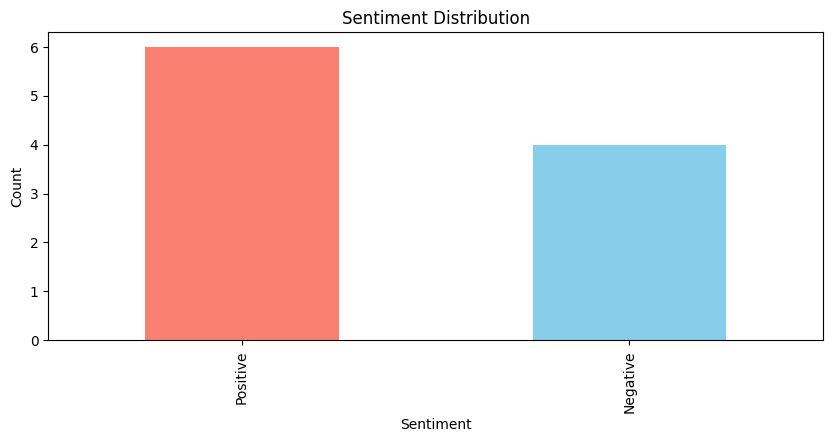

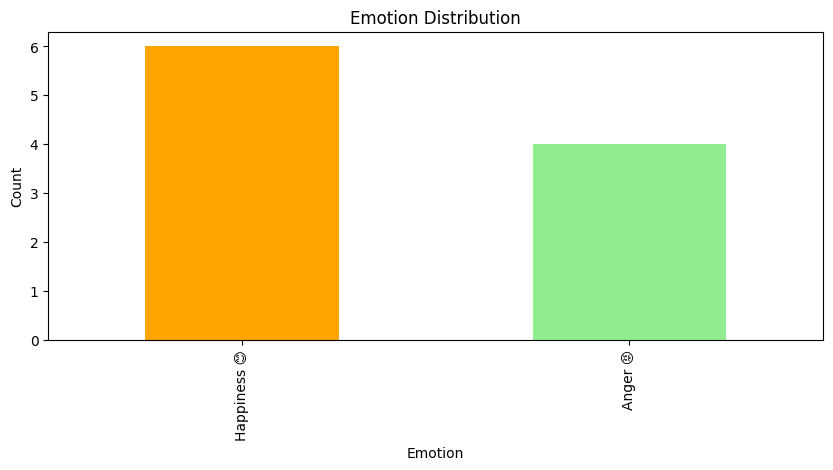

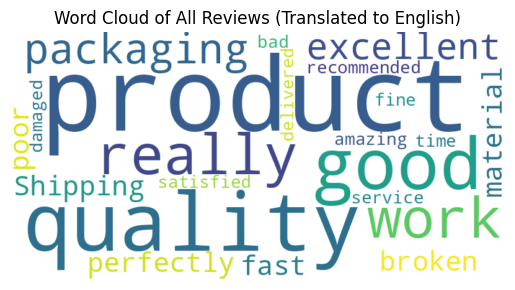


🧠 INSIGHTS SUMMARY
✅ Total Reviews Analyzed: 10
😃 Positive Reviews: 6
😡 Negative Reviews: 4
😐 Neutral Reviews: 0

⭐ Top 3 Positive Reviews:
1. This product is really good and works perfectly!
2. El envío fue muy rápido y el empaque excelente.
3. Das ist ein erstaunliches Produkt, sehr zufrieden!

💢 Top 3 Negative Reviews:
1. Le produit est cassé et ne fonctionne pas.
2. இந்த பொருள் தரம் மிகவும் மோசமாக உள்ளது.
3. Packaging was damaged but the product is fine.


In [ ]:
# ==============================================================
# 📦 Multilingual Sentiment & Emotion Analysis on E-Commerce Reviews Dataset
# ==============================================================

import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --------------------------------------------------------------
# 1️⃣ Sample multilingual e-commerce reviews (you can replace with your own CSV)
# --------------------------------------------------------------
data = {
    "review": [
        "This product is really good and works perfectly!",
        "Le produit est cassé et ne fonctionne pas.",  # French
        "El envío fue muy rápido y el empaque excelente.",  # Spanish
        "இந்த பொருள் தரம் மிகவும் மோசமாக உள்ளது.",  # Tamil
        "Das ist ein erstaunliches Produkt, sehr zufrieden!",  # German
        "บริการดีมาก ฉันชอบสินค้านี้มาก",  # Thai
        "Packaging was damaged but the product is fine.",
        "La qualità è pessima, non consigliato.",  # Italian
        "ఉత్పత్తి నాణ్యత అద్భుతంగా ఉంది.",  # Telugu
        "उत्पाद की डिलीवरी समय पर हुई और बहुत अच्छी गुणवत्ता है।"  # Hindi
    ]
}
df = pd.DataFrame(data)

print("📋 Sample of dataset:")
display(df.head())

# --------------------------------------------------------------
# 2️⃣ Apply the previously defined analyze_text() function
# --------------------------------------------------------------
tqdm.pandas()

results = df['review'].progress_apply(analyze_text)
df_results = pd.DataFrame(list(results))

print("\n✅ Analysis Completed for all reviews!")
display(df_results)

# --------------------------------------------------------------
# 3️⃣ Sentiment & Emotion Distribution Visualization
# --------------------------------------------------------------
plt.figure(figsize=(10,4))
df_results['Sentiment'].value_counts().plot(kind='bar', color=['salmon','skyblue','lightgreen'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,4))
df_results['Emotion'].value_counts().plot(kind='bar', color=['orange','lightgreen','violet'])
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

# --------------------------------------------------------------
# 4️⃣ Word Cloud of all translated reviews
# --------------------------------------------------------------
text_all = " ".join(df_results['Translated Text'])
wc = WordCloud(width=800, height=400, background_color="white").generate(text_all)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Reviews (Translated to English)")
plt.show()

# --------------------------------------------------------------
# 5️⃣ Insights Summary
# --------------------------------------------------------------
print("\n🧠 INSIGHTS SUMMARY")
positive = df_results[df_results['Sentiment'] == 'Positive']
negative = df_results[df_results['Sentiment'] == 'Negative']

print(f"✅ Total Reviews Analyzed: {len(df_results)}")
print(f"😃 Positive Reviews: {len(positive)}")
print(f"😡 Negative Reviews: {len(negative)}")
print(f"😐 Neutral Reviews: {len(df_results) - len(positive) - len(negative)}")

print("\n⭐ Top 3 Positive Reviews:")
for i, text in enumerate(positive['Original Text'].head(3), 1):
    print(f"{i}. {text}")

print("\n💢 Top 3 Negative Reviews:")
for i, text in enumerate(negative['Original Text'].head(3), 1):
    print(f"{i}. {text}")
